In [1]:
import logging
import warnings

import mne
import xarray as xr
import yaml
from megspikes.pipeline import aspire_alphacsc_pipeline
from megspikes.visualization.report import report_detection, report_atoms_library

from utils.utils import setup_case_manager

warnings.filterwarnings("ignore", category=DeprecationWarning)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test debug")
logging.info("test info")

from sklearn import set_config
set_config(display='diagram')
%load_ext autoreload
%autoreload 2


INFO:root:test info


In [2]:
case = setup_case_manager(1)

detection_results = xr.open_dataset(case.dataset)

In [3]:
# Inspect dataset

detection_results

<xarray.Dataset>
Dimensions:                            (channel: 351, sensors: 2, ica_component: 20, time: 146800, ica_component_property: 5, run: 4, detection_property: 10, alphacsc_atom: 3, atom_v_time: 100, alphacsc_atom_property: 6, atoms_library_property: 4)
Coordinates:
  * channel                            (channel) int64 0 1 2 3 ... 348 349 350
  * sensors                            (sensors) object 'grad' 'mag'
  * ica_component                      (ica_component) int64 0 1 2 ... 17 18 19
  * time                               (time) float64 0.0 0.005 ... 734.0 734.0
  * ica_component_property             (ica_component_property) object 'mni_x...
  * run                                (run) int64 0 1 2 3
  * detection_property                 (detection_property) object 'ica_detec...
  * alphacsc_atom                      (alphacsc_atom) int64 0 1 2
  * atom_v_time                        (atom_v_time) float64 0.0 1.01 ... 100.0
  * alphacsc_atom_property             (alphacsc_atom_property) object 'mni_x...
  * atoms_library_property             (atoms_library_property) object 'libra...
Data variables:
    channel_names                      (channel) object ...
    ica_sources                        (sensors, ica_component, time) float64 ...
    ica_components                     (ica_component, channel) float64 ...
    ica_component_properties           (sensors, ica_component, ica_component_property) float64 ...
    ica_component_selection            (run, sensors, ica_component) float64 ...
    detection_properties               (run, sensors, detection_property, time) float64 ...
    alphacsc_z_hat                     (run, sensors, alphacsc_atom, time) float64 ...
    alphacsc_v_hat                     (run, sensors, alphacsc_atom, atom_v_time) float64 ...
    alphacsc_u_hat                     (run, alphacsc_atom, channel) float64 ...
    alphacsc_atoms_properties          (run, sensors, alphacsc_atom, alphacsc_atom_property) float64 ...
    alphacsc_atoms_library_properties  (atoms_library_property, time) float64 ...
Attributes:
    grad:     [  0   1   3   4   6   7   9  10  12  13  15  16  18  19  21  2...
    mag:      [  2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  4...

In [7]:
# explore dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr



In [ ]:
# the number of events in the libraries equals the alpha csc dection in mag and grad
%matplotlib qt 
events_lib_tot  = np.sum(detection_results.alphacsc_atoms_library_properties[0].values)
events_lib_grad = np.sum(detection_results.detection_properties.loc[dict(sensors = 'grad', detection_property = 'alphacsc_detection')].values)
events_lib_mag  = np.sum(detection_results.detection_properties.loc[dict(sensors = 'mag', detection_property = 'alphacsc_detection')].values) 

print("the total number of events is " + str(events_lib_tot) + " = " + str(events_lib_grad) + " (grad) " +  str(events_lib_mag) + " (mag) ")

In [ ]:
# compare z hat with atoms time stamps

%matplotlib qt 

from scipy import signal, stats
import matplotlib.lines as lines

run  = 0 # there is only 1
sens = 0 # grad 
atom = 0 # N atom 
z_hat = detection_results.alphacsc_z_hat[run][sens][atom]

# ev1
ev1 = np.nonzero(detection_results.detection_properties.loc[dict( detection_property= 'alphacsc_detection', sensors = 'grad')].values)[1]
alphacsc_atom = detection_results.detection_properties.loc[dict( detection_property = 'alphacsc_atom', sensors = 'grad')].values[0]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
 

# plot zhat and superimpose events time stamp
# ( consider that the events are searched at zhat peak immediately preceding the ica detections:
# the zhat peak set the beginning of a 0.5 s window where the spike appears, therefore an alignment
# must be done for the events clustering. see detection.SelectAlphacscEvents for details)

ax1 = plt.subplot(2,1,1)
ax1.plot(detection_results.time, z_hat)
ax1.stem(ev1/200, np.ones(len(ev1))*7e-10,'r')
ax1.set_title('z_hat') 

# add threshold as horizontal bar
z_threshold = 2.5 # default value
z_mad = stats.median_abs_deviation(z_hat[z_hat > 0])
threshold = np.median(z_hat[z_hat > 0]) + z_mad*z_threshold 
ax1.add_artist(lines.Line2D([0, detection_results.time[-1]],[threshold, threshold],color ='g'))

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.stem(ev1/200,alphacsc_atom[ev1])
ax2.set_title('which atom') 




In [4]:
detection_results.ica_component_selection

<xarray.DataArray 'ica_component_selection' (run: 4, sensors: 2, ica_component: 20)>
array([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]],

       [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]],

       [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]]])
Coordinates:
  * sensors        (sensors) object 'grad' 'mag'
  * ica_component  (ica_component) int64 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
  * run            (run) int64 0 1 2 3

In [6]:
from megspikes.visualization.visualization import DetectionsViewer
pp = DetectionsViewer(detection_results, case)

/home/cdm/miniconda3/envs/megspikes-pipeline/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


Column
    [0] Param(DetectionsViewer, default_layout=<class 'panel.layout.base...., name='Select', parameters=['sensors'], width=800)
    [1] Row(height=600, scroll=True, sizing_mode='fixed', width=1000)
        [0] ParamMethod(method)
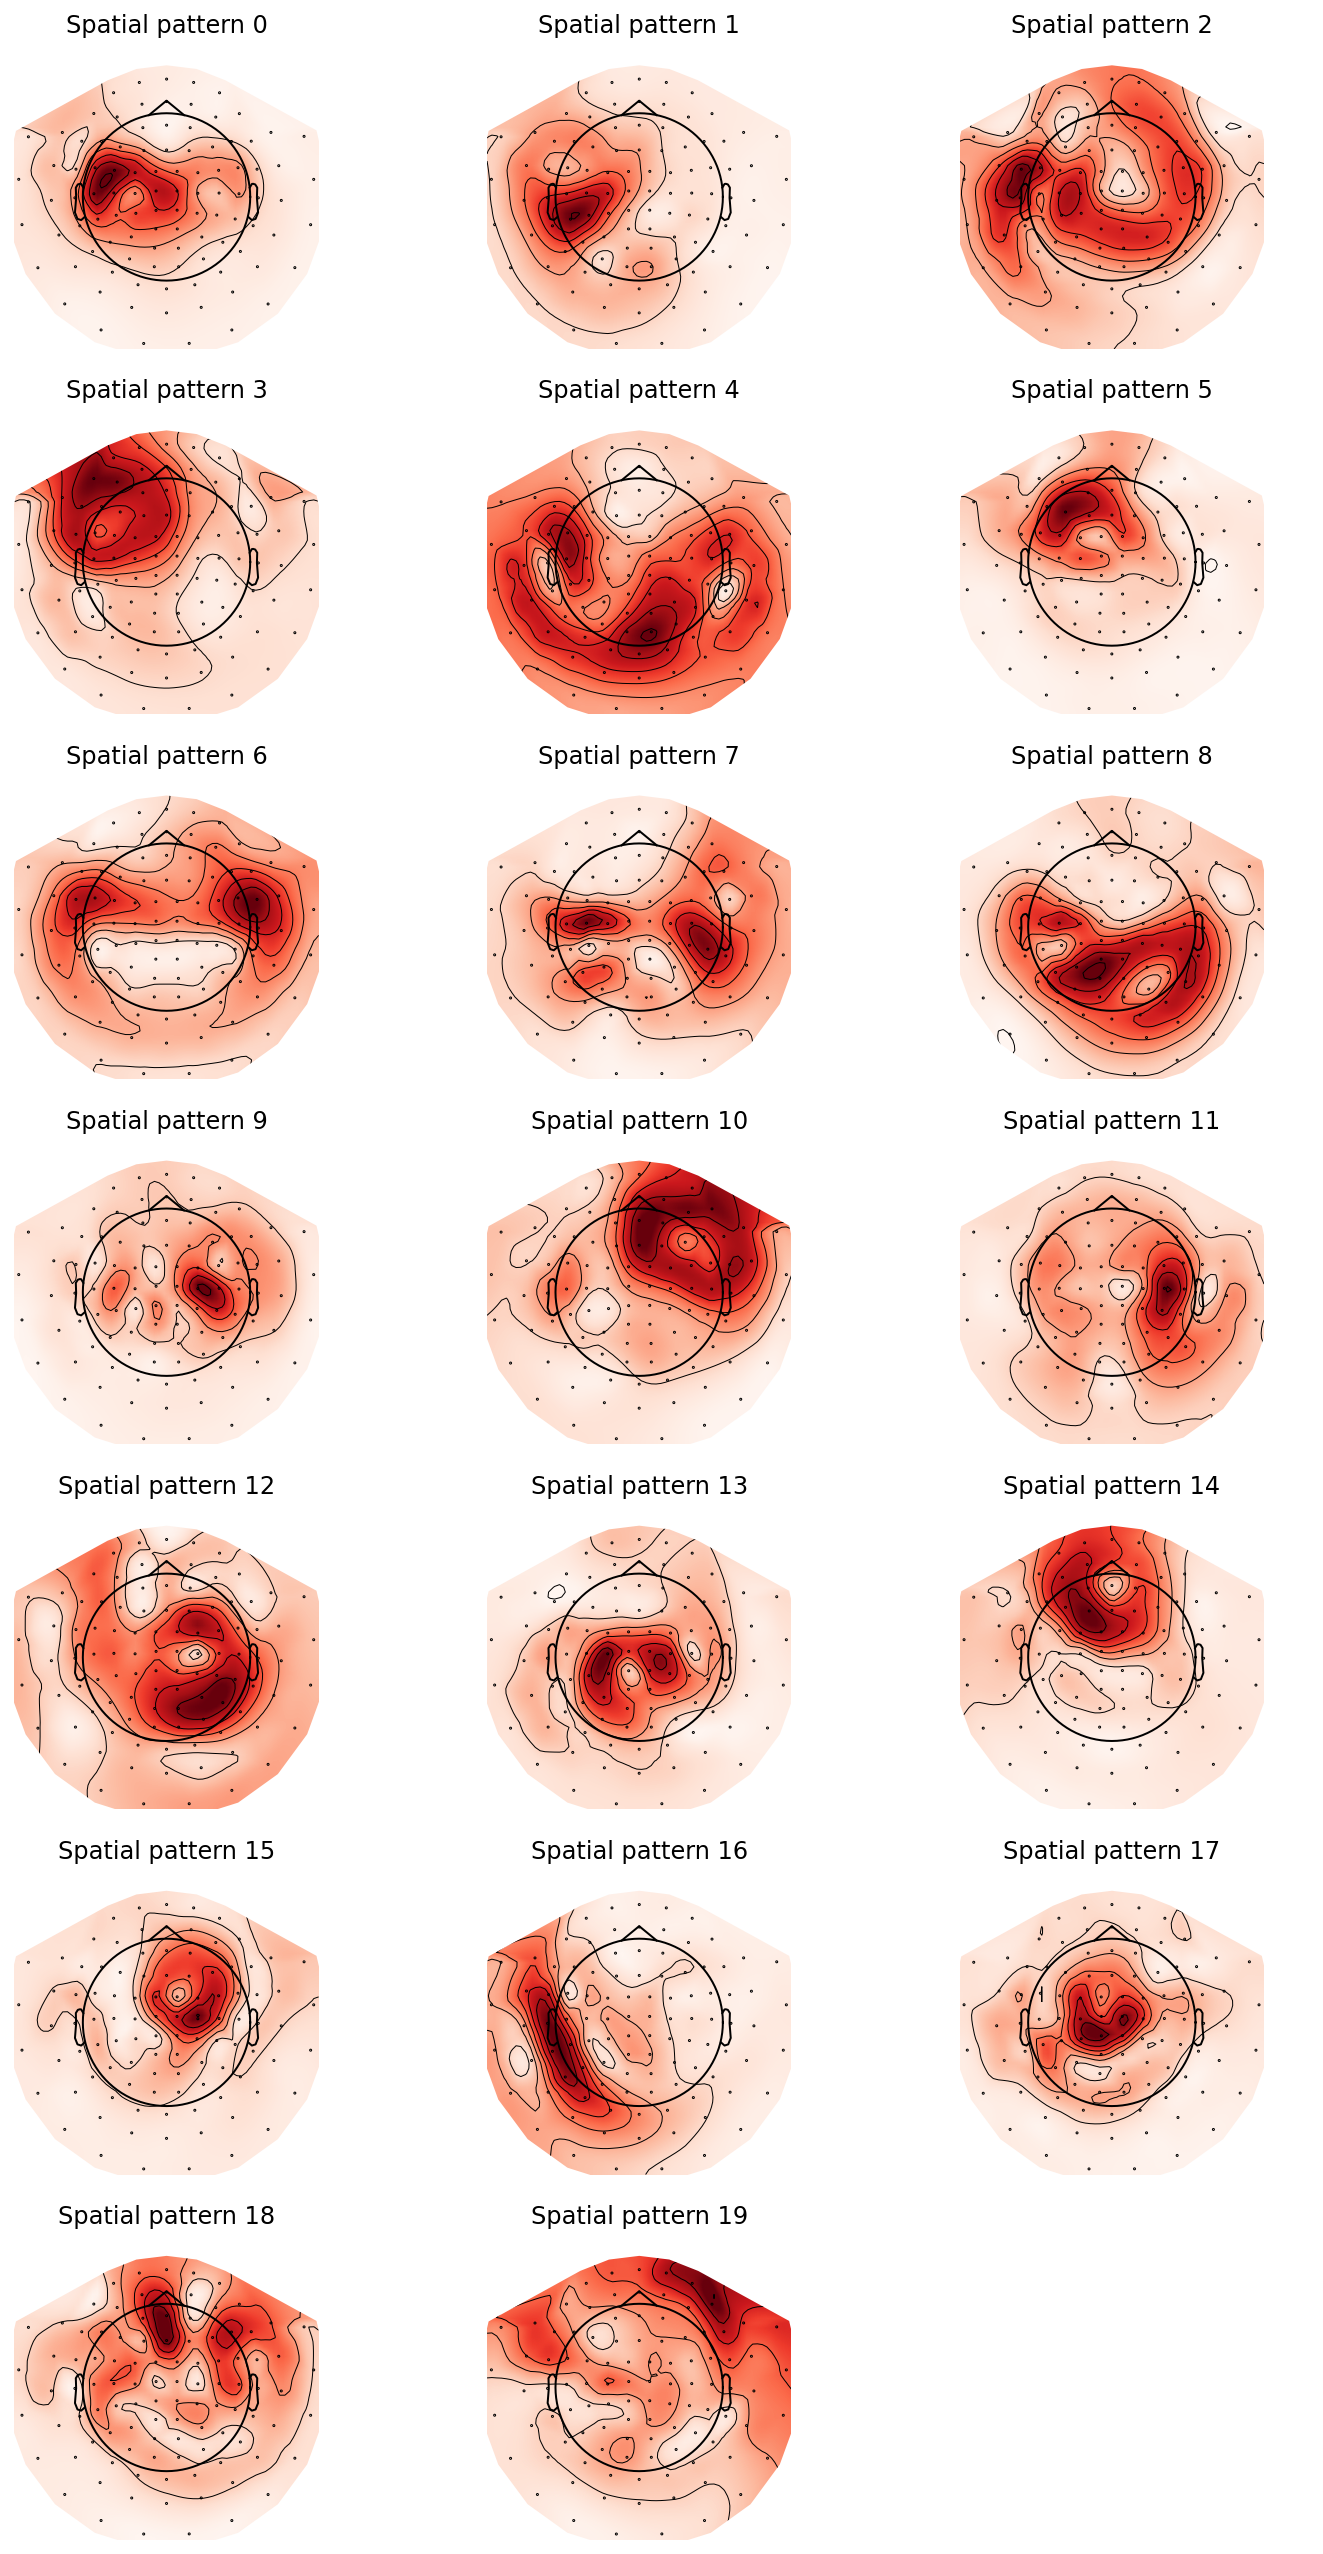

In [7]:
app = pp.view_ica()
# app.show()
app

Column
    [0] Param(DetectionsViewer, default_layout=<class 'panel.layout.base...., name='Select', parameters=['sensors', 'run'], width=800)
    [1] Row(height=600, scroll=True, sizing_mode='fixed', width=1000)
        [0] ParamMethod(method)
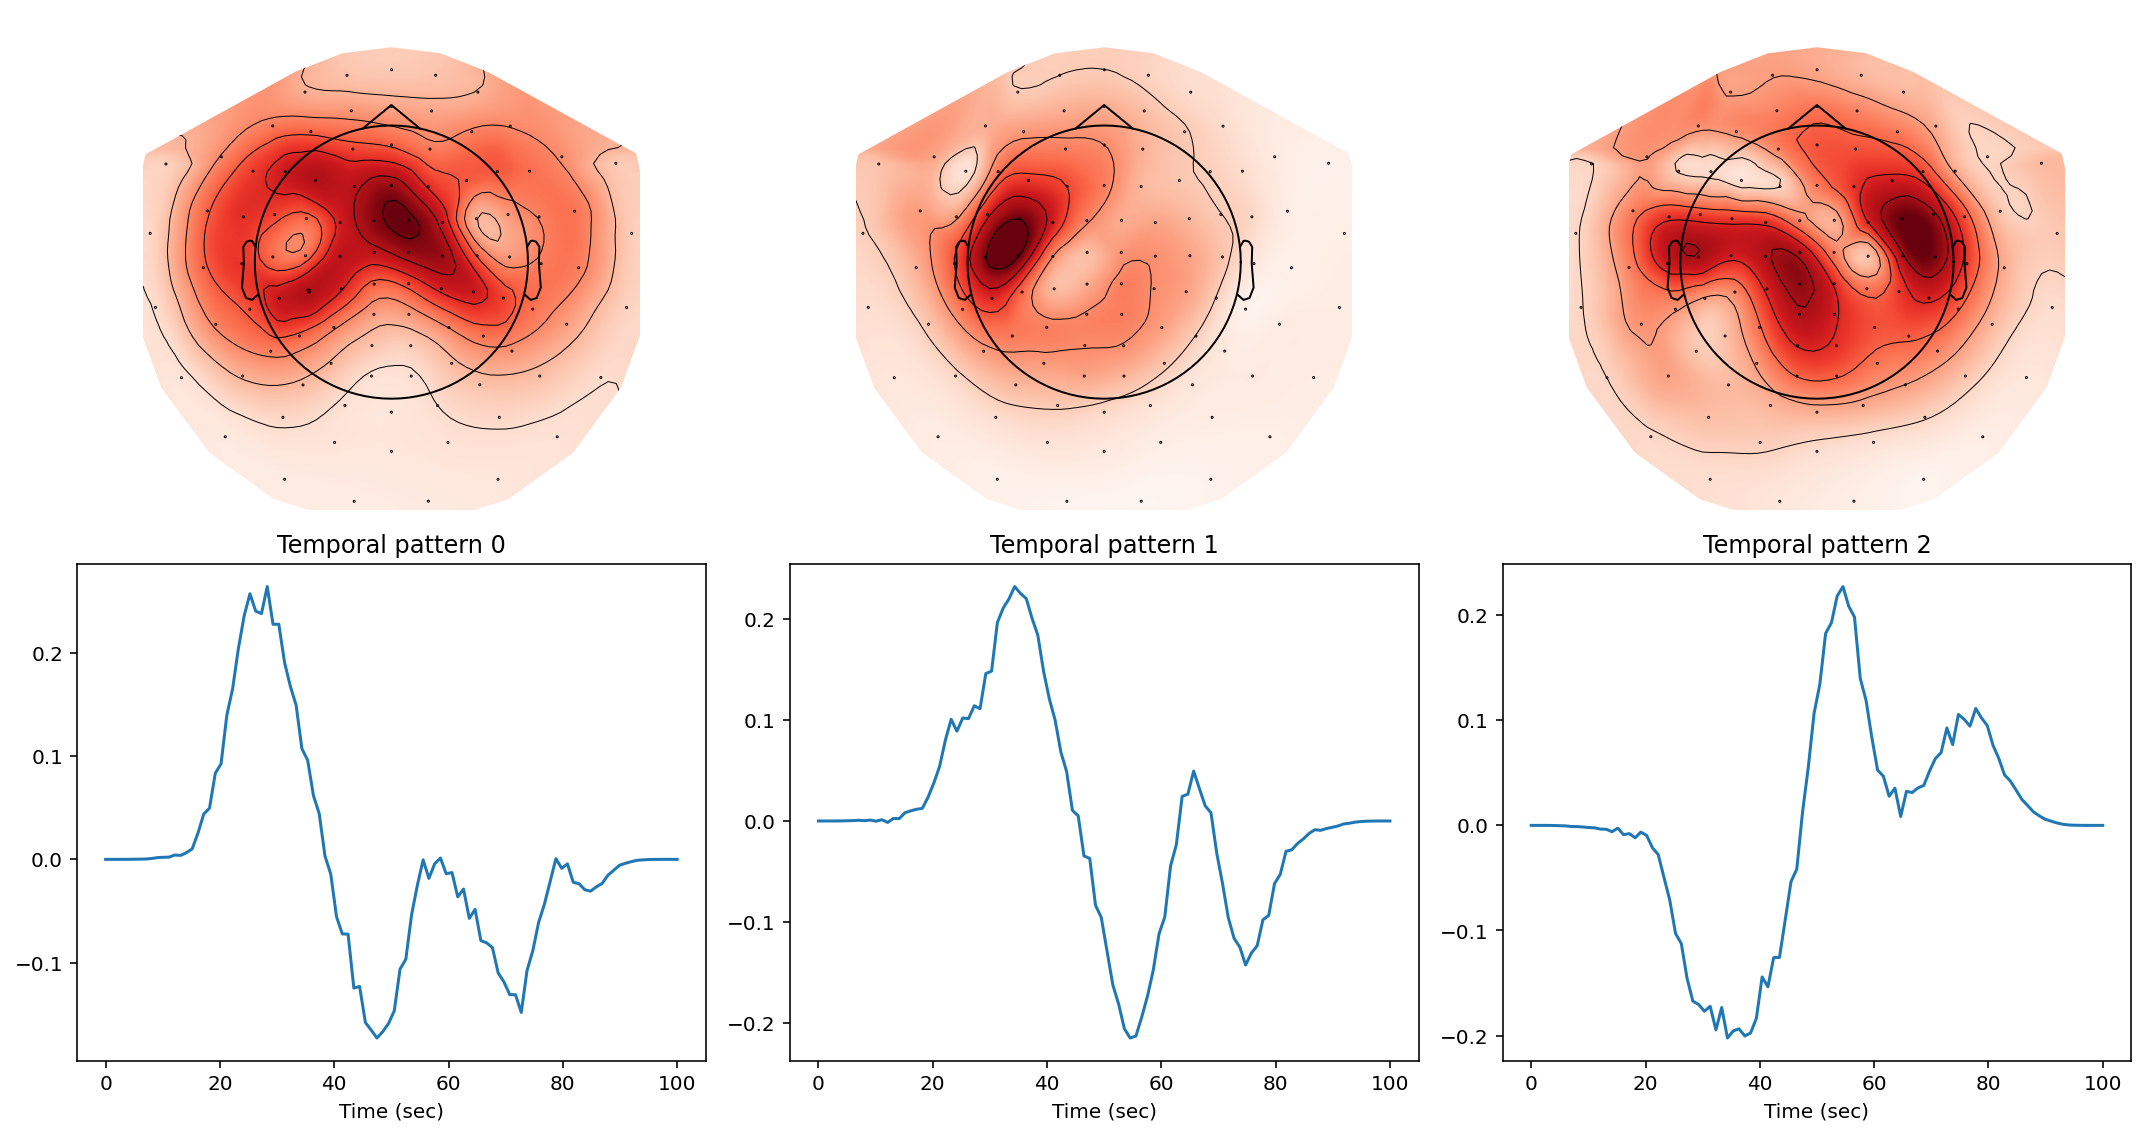

In [8]:
app = pp.view_alphacsc_atoms()
# app.show()
app